<a href="https://colab.research.google.com/github/narendra974/insidedeeplearning/blob/main/CNN_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torchvision
from torchvision import transforms

mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

x_example, y_example = mnist_data_train[0]
print(x_example.shape)

torch.Size([1, 28, 28])


In [3]:
type(x_example)

torch.Tensor

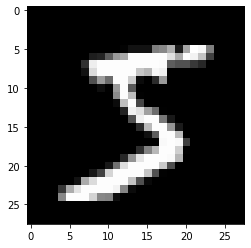

In [6]:
import matplotlib.pyplot as plt

plt.imshow(x_example[0, :], cmap='gray')

In [9]:
import torch

x_as_color = torch.stack([x_example[0, :], x_example[0, :], x_example[0, :]], dim=0)

print(x_as_color.shape)

torch.Size([3, 28, 28])


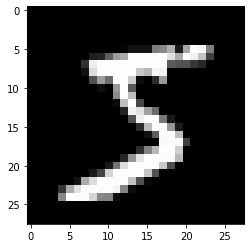

In [11]:
plt.imshow(x_as_color.permute(1, 2, 0))

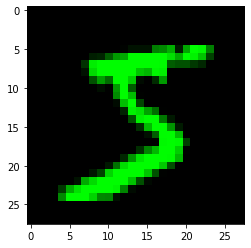

In [12]:
x_as_color[0, :] = 0 # no red channel
x_as_color[2, :] = 0 # no green channel
plt.imshow(x_as_color.permute(1, 2, 0))


In [15]:
filter = [[0, 1, 0], [0, 1, 0], [0, 1, 0]]
input = [ [0, 0, 1, 1, 0, 0],
          [0, 1, 0, 1, 0, 0],
          [0, 0, 0, 1, 0, 0],
          [0, 0, 0, 1, 0, 0],
          [0, 0, 0, 1, 1, 0], 
          [0, 1, 1, 1, 1, 1] 
        ]

height, width = len(input), len(input[0])
output = []

for i in range(height-len(filter)+1):
  rowout = []
  for j in range(width-len(filter)+1):
    result = 0
    for k_i in range(len(filter)):
      for k_j in range(len(filter)):
        result += input[i+k_i][j+k_j] * filter[k_i][k_j]
    rowout.append(result)
  output.append(rowout)

print(output)


[[1, 1, 3, 0], [1, 0, 3, 0], [0, 0, 3, 1], [1, 1, 3, 2]]


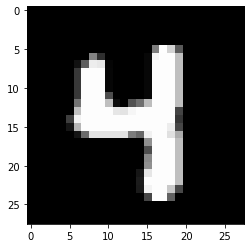

In [17]:
from scipy.signal import convolve
img_index = 58
x_example, y_example = mnist_data_train[img_index]
x_exampe_gray = x_example[0, :]
plt.imshow(x_exampe_gray, vmin=0, vmax=1, cmap='gray')

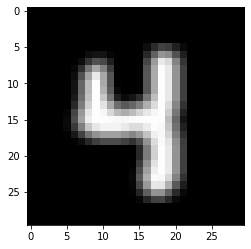

In [21]:
blur_filter = [ 
               [1/9, 1/9, 1/9],
               [1/9, 1/9, 1/9],
               [1/9, 1/9, 1/9]
              ]
blurry_img = convolve(x_exampe_gray, blur_filter)
plt.imshow(blurry_img, vmin=0, vmax=1, cmap='gray')
plt.show()

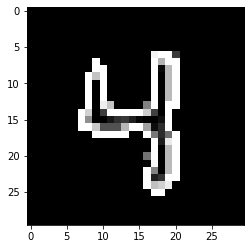

In [22]:
edge_filter = [ 
               [-1, -1, -1],
               [-1, +8, -1],
               [-1, -1, -1]
              ]
edge_img = convolve(x_exampe_gray, edge_filter)
plt.imshow(edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

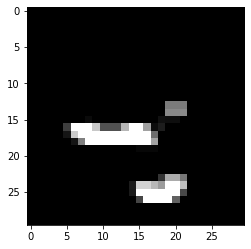

In [23]:
horizontal_filter = [ 
               [-1, -1, -1],
               [0, 0, 0],
               [1, 1, 1]
              ]
horizontal_img = convolve(x_exampe_gray, horizontal_filter)
plt.imshow(horizontal_img, vmin=0, vmax=1, cmap='gray')
plt.show()

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm


def moveTo(obj, device):
  if isinstance(obj, list):
    return [moveTo(x, device) for x in obj]
  elif isinstance(obj, tuple):
    return tuple(moveTo(list(obj), device))
  elif isinstance(obj, set):
    return set(moveTo(list(obj), device))
  elif isinstance(obj, dict):
    to_ret = dect()
    for key, value in obj.items():
      to_ret[moveTo(key, device)] = moveTo(value,device)
  elif hasattr(obj,"to"):
    return obj.to(device)
  else:
    return object


def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.

        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch


def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)


def prediction(model, img):
  with torch.no_grad():
    w, h = img.shape
    if not isinstance(img, torch.Tensor):
      img = torch.tensor(img)
    x = img.reshape(1, -1, w, h)
    logits = model(x)
    y_hat = F.softmax(logits, dim=1)
    return y_hat.numpy().flatten()


In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
B = 32
mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B, shuffle=True)

In [26]:
D = 28*28
C = 1

classes = 10
filters = 16
K = 3
loss_func = nn.CrossEntropyLoss()


model_linear = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, 256),
    nn.Tanh(), 
    nn.Linear(256, classes)
)

fc_results = train_simple_network(model_linear, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy' : accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

In [27]:
from torchsummary import summary
summary(model_linear, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              Tanh-3                  [-1, 256]               0
            Linear-4                   [-1, 10]           2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.78
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


In [28]:
model_cnn = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=K//2),
    nn.Tanh(),
    nn.Flatten(), 
    nn.Linear(filters*D, classes)
)

cnn_results = train_simple_network(model_cnn, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy' : accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

In [30]:
summary(model_cnn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              Tanh-2           [-1, 16, 28, 28]               0
           Flatten-3                [-1, 12544]               0
            Linear-4                   [-1, 10]         125,450
Total params: 125,610
Trainable params: 125,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.48
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


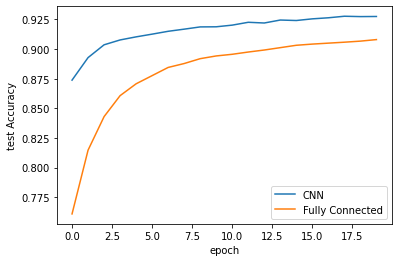

In [33]:
import seaborn as sns
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_results, label='Fully Connected')

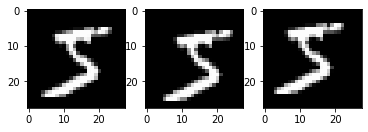

In [34]:
# https://numpy.org/doc/stable/reference/generated/numpy.roll.html   to understand about roll functionality.

img_index = 0
img, correct_class = mnist_data_train[img_index]
img = img[0, :]
# move to the upper left & lower right
img_lr = np.roll(np.roll(img, 1, axis=1), 1, axis=0)
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0)

f, axarr = plt.subplots(1, 3)

axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(img_lr, cmap='gray')
axarr[2].imshow(img_ul, cmap='gray')

In [39]:
model = model_cnn.cpu().eval()

img_pred = prediction(model, img)
img_lr_pred = prediction(model, img_lr)
img_ul_pred = prediction(model, img_ul)

print("Org Img Class {} Prob : ".format(correct_class), img_pred[correct_class])
print("Lower Right Img Class {} Prob : ".format(correct_class), img_lr_pred[correct_class])
print("Upper Left Img Class {} Prob : ".format(correct_class), img_ul_pred[correct_class])

Org Img Class 5 Prob :  0.7661772
Lower Right Img Class 5 Prob :  0.47336906
Upper Left Img Class 5 Prob :  0.3733657


In [40]:
model_cnn_pool = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.MaxPool2d(2), 

    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(2*filters*D//4**2, classes)
)

cnn_results_poll = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy' : accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

In [41]:
summary(model_cnn_pool, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              Tanh-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              Tanh-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           2,320
              Tanh-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]           4,640
              Tanh-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
             Tanh-11           [-1, 32, 14, 14]               0
           Conv2d-12           [-1, 32, 14, 14]           9,248
             Tanh-13           [-1, 32, 14, 14]               0
        MaxPool2d-14             [-1, 3

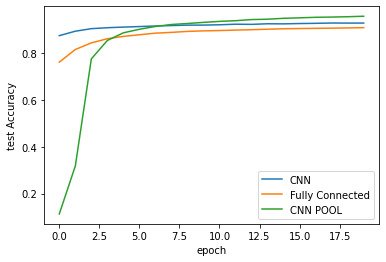

In [42]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_results, label='Fully Connected')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_poll, label='CNN POOL')

In [43]:
model = model_cnn_pool.cpu().eval()

img_pred = prediction(model, img)
img_lr_pred = prediction(model, img_lr)
img_ul_pred = prediction(model, img_ul)

print("Org Img Class {} Prob : ".format(correct_class), img_pred[correct_class])
print("Lower Right Img Class {} Prob : ".format(correct_class), img_lr_pred[correct_class])
print("Upper Left Img Class {} Prob : ".format(correct_class), img_ul_pred[correct_class])

Org Img Class 5 Prob :  0.7127075
Lower Right Img Class 5 Prob :  0.7242716
Upper Left Img Class 5 Prob :  0.82208765
